<a href="https://colab.research.google.com/github/Tokelo22/My-Package/blob/master/Copy_of_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDSA: Sendy Logistics Challenge

##Introduction

---



In this project.....................

##Import Libraries

---



In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb


##Import datasets

---



In [15]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
riders = pd.read_csv('Riders.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')


##Exploratory Data Analysis

---



In [16]:
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


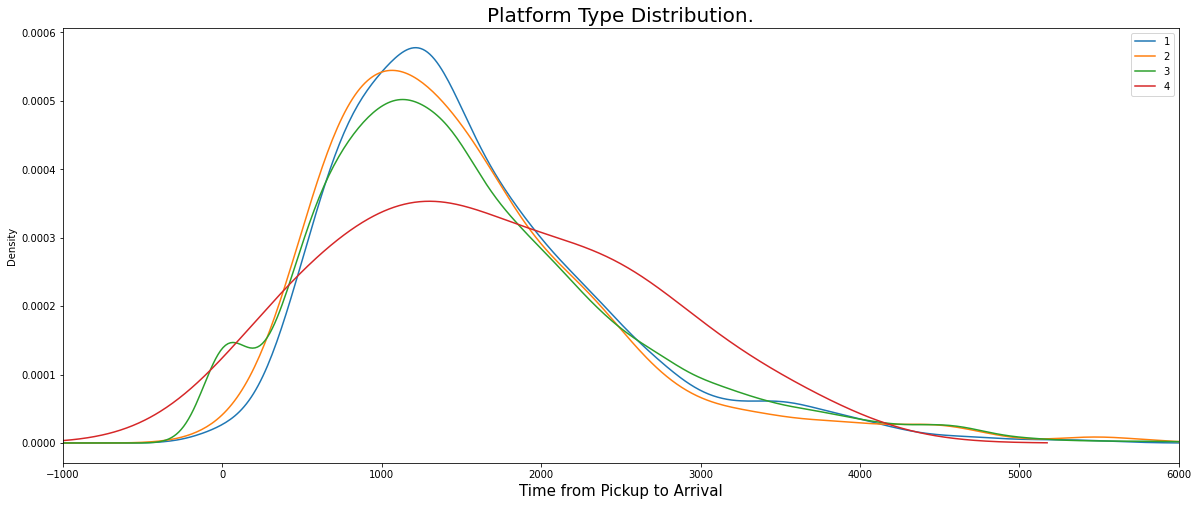

In [17]:
train.groupby('Platform Type')['Time from Pickup to Arrival'].plot(kind='kde', figsize=[20,8], legend=True)
plt.xlim([-1000,6000.0])
plt.xlabel('Time from Pickup to Arrival',fontsize=15)
plt.title('Platform Type Distribution.',fontsize=20)
plt.show()

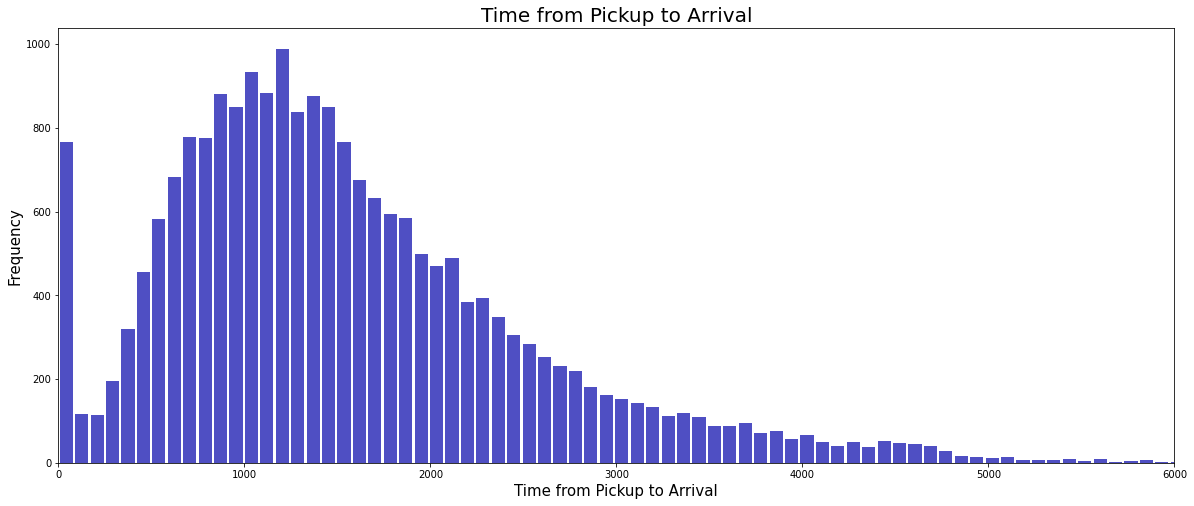

In [18]:
#fig, ax = plt.subplots()
train.hist(column='Time from Pickup to Arrival', figsize=(20,8), grid=False, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
#train.plot.hist(density=True, ax=ax)
plt.xlabel("Time from Pickup to Arrival",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Time from Pickup to Arrival",fontsize=20)
plt.xlim([0.0,6000.0])
plt.show()

In [19]:
train = train[(train['Time from Pickup to Arrival'] > 60)]
train

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21195,Order_No_9932,User_Id_3582,Bike,3,Business,2,6,1:08:34 PM,2,6,1:25:40 PM,2,6,1:52:11 PM,2,6,1:54:36 PM,2,6,2:33:21 PM,17,29.0,NaN,-1.238406,36.871870,-1.276549,36.766981,Rider_Id_34,2325
21197,Order_No_22892,User_Id_1796,Bike,3,Business,13,6,10:13:34 AM,13,6,10:13:41 AM,13,6,10:20:04 AM,13,6,10:33:27 AM,13,6,10:46:17 AM,7,26.0,NaN,-1.307143,36.825009,-1.331619,36.847976,Rider_Id_155,770
21198,Order_No_2831,User_Id_2956,Bike,3,Business,7,4,5:06:16 PM,7,4,5:07:09 PM,7,4,5:30:17 PM,7,4,5:50:52 PM,7,4,6:40:05 PM,20,29.2,NaN,-1.286018,36.897534,-1.258414,36.804800,Rider_Id_697,2953
21199,Order_No_6174,User_Id_2524,Bike,1,Personal,4,3,9:31:39 AM,4,3,9:31:53 AM,4,3,9:38:59 AM,4,3,9:45:15 AM,4,3,10:08:15 AM,13,15.0,NaN,-1.250030,36.874167,-1.279209,36.794872,Rider_Id_347,1380


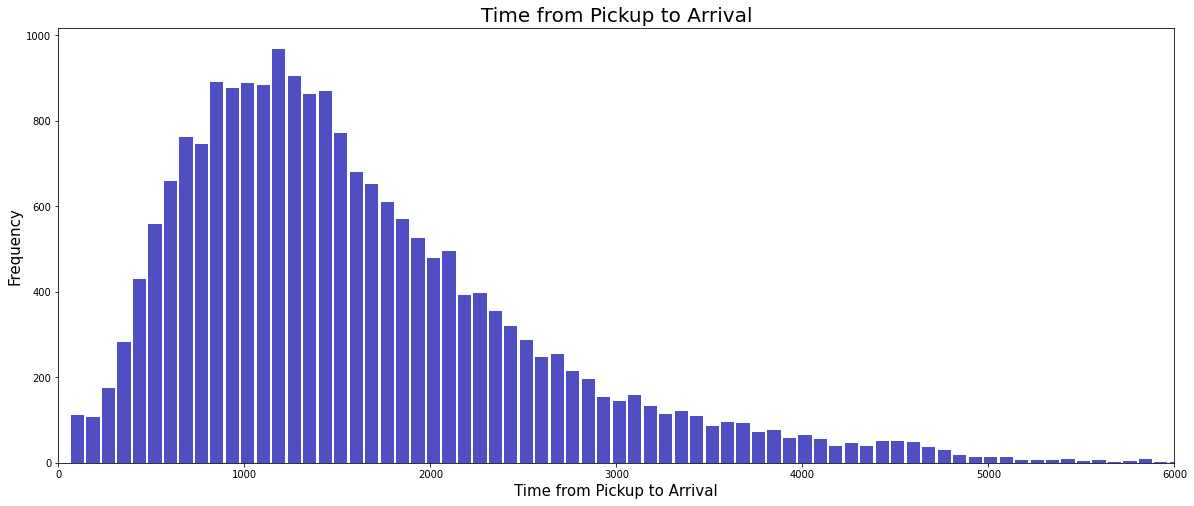

In [20]:
train.hist(column='Time from Pickup to Arrival', figsize=(20,8), grid=False, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel("Time from Pickup to Arrival",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Time from Pickup to Arrival",fontsize=20)
plt.xlim([0,6000.0])
plt.show()

In [21]:
test.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [22]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20461 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   20461 non-null  object 
 1   User Id                                    20461 non-null  object 
 2   Vehicle Type                               20461 non-null  object 
 3   Platform Type                              20461 non-null  int64  
 4   Personal or Business                       20461 non-null  object 
 5   Placement - Day of Month                   20461 non-null  int64  
 6   Placement - Weekday (Mo = 1)               20461 non-null  int64  
 7   Placement - Time                           20461 non-null  object 
 8   Confirmation - Day of Month                20461 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            20461 non-null  int64  
 10  Confirmation - Time   

Convert time to datetime format.

In [23]:
train['Placement - Time'] =  (pd.to_timedelta(train['Placement - Time']).astype(int)/60)
train['Confirmation - Time'] =  (pd.to_timedelta(train['Confirmation - Time']).astype(int)/60)
train['Arrival at Pickup - Time'] =  pd.to_timedelta(train['Arrival at Pickup - Time']).astype(int)/60
train['Arrival at Destination - Time'] =  pd.to_timedelta(train['Arrival at Destination - Time']).astype(int)/60
train['Pickup - Time'] =  pd.to_timedelta(train['Pickup - Time']).astype(int)/60

test['Placement - Time'] =  pd.to_timedelta(test['Placement - Time']).astype(int)/60
test['Confirmation - Time'] =  pd.to_timedelta(test['Confirmation - Time']).astype(int)/60
test['Arrival at Pickup - Time'] =  pd.to_timedelta(test['Arrival at Pickup - Time']).astype(int)/60
test['Pickup - Time'] =  pd.to_timedelta(test['Pickup - Time']).astype(int)/60

From the above table we see that precipitation only has less than 3% of the values  in the table, hence we are removing it from our data.
Removed the Vehichle type since it is the same vehicle in this instance a bike.
While for the missing values in Temperature we replace them with the average/mean of the number in the Temperature column.

In [24]:
train.drop('Precipitation in millimeters', axis=1, inplace=True)
train.drop('Vehicle Type', axis=1, inplace=True)
train.drop('Order No', axis=1, inplace=True)   #Comment the text
train.drop('Arrival at Destination - Day of Month', axis=1, inplace=True)   #Comment the text
train.drop('Arrival at Destination - Weekday (Mo = 1)', axis=1, inplace=True)   #Comment the text
train.drop('Arrival at Destination - Time', axis=1, inplace=True)   #Comment the text
train.drop('User Id', axis=1, inplace=True)   #Comment the text
train.drop('Temperature', axis=1, inplace=True)   #Comment the text
train.drop('Rider Id', axis=1, inplace=True)   #Comment the text
test.drop('Precipitation in millimeters', axis=1, inplace=True)
test.drop('Vehicle Type', axis=1, inplace=True)
test.drop('Order No', axis=1, inplace=True)    #Comment the text
test.drop('Temperature', axis=1, inplace=True)   #Comment the text
test.drop('User Id', axis=1, inplace=True)    #Comment the text
test.drop('Rider Id', axis=1, inplace=True)    #Comment the text

train = train.fillna(train.mean())
test = test.fillna(train.mean())

In [25]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20461 entries, 0 to 21200
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Platform Type                         20461 non-null  int64  
 1   Personal or Business                  20461 non-null  object 
 2   Placement - Day of Month              20461 non-null  int64  
 3   Placement - Weekday (Mo = 1)          20461 non-null  int64  
 4   Placement - Time                      20461 non-null  float64
 5   Confirmation - Day of Month           20461 non-null  int64  
 6   Confirmation - Weekday (Mo = 1)       20461 non-null  int64  
 7   Confirmation - Time                   20461 non-null  float64
 8   Arrival at Pickup - Day of Month      20461 non-null  int64  
 9   Arrival at Pickup - Weekday (Mo = 1)  20461 non-null  int64  
 10  Arrival at Pickup - Time              20461 non-null  float64
 11  Pickup - Day of

Encoding the data for 'Personal or Business' column into dummy variables.

In [26]:
train['Personal or Business'] = pd.get_dummies(train['Personal or Business'])
test['Personal or Business'] = pd.get_dummies(test['Personal or Business'])

The 5 Number Summary.

In [27]:
train.describe().round(2)

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,20461.00,20461.00,20461.00,20461.00,2.046100e+04,20461.00,20461.00,2.046100e+04,20461.00,20461.00,2.046100e+04,20461.00,20461.00,2.046100e+04,20461.00,20461.00,20461.00,20461.00,20461.00,20461.00
mean,2.74,0.81,15.64,3.24,4.354120e+11,15.64,3.24,4.310830e+11,15.64,3.24,4.244598e+11,15.64,3.24,4.188547e+11,9.62,-1.28,36.81,-1.28,36.81,1612.87
std,0.63,0.39,8.79,1.57,2.450855e+11,8.79,1.57,2.449851e+11,8.79,1.57,2.454086e+11,8.79,1.57,2.455514e+11,5.67,0.03,0.04,0.04,0.05,959.30
min,1.00,0.00,1.00,1.00,6.001667e+10,1.00,1.00,6.000000e+10,1.00,1.00,6.005000e+10,1.00,1.00,6.000000e+10,1.00,-1.44,36.65,-1.43,36.61,62.00
25%,3.00,1.00,8.00,2.00,1.863333e+11,8.00,2.00,1.872167e+11,8.00,2.00,1.873000e+11,8.00,2.00,1.876333e+11,5.00,-1.30,36.78,-1.30,36.79,930.00
50%,3.00,1.00,15.00,3.00,5.277000e+11,15.00,3.00,5.163000e+11,15.00,3.00,4.348833e+11,15.00,3.00,3.510667e+11,8.00,-1.28,36.81,-1.28,36.81,1406.00
75%,3.00,1.00,23.00,5.00,6.629833e+11,23.00,5.00,6.621333e+11,23.00,5.00,6.616833e+11,23.00,5.00,6.628167e+11,13.00,-1.26,36.83,-1.26,36.83,2072.00
max,4.00,1.00,31.00,7.00,7.799833e+11,31.00,7.00,7.799667e+11,31.00,7.00,7.799667e+11,31.00,7.00,7.799833e+11,49.00,-1.15,36.99,-1.03,37.02,7883.00


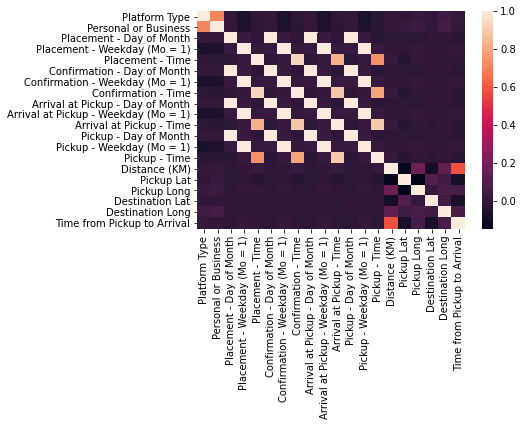

In [28]:
corr = train.corr()
sns.heatmap(corr)

##Data Preprocess

In [29]:
X = train.iloc[:,:-1].values    #Assign x values 
y = train.iloc[:,-1].values     #Assign y values 


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)  #Split the data to test and train

##Modelling

###Model 1 - Multiple Linear Regression

platform personal or be pickupday of month pick upday of week pick up time pick up lat and longi destination lati and longi distance temperature 

In [31]:
mlm = LinearRegression()
mlm.fit(X_train,y_train)

y_pred_mlm = mlm.predict(X_test)

training_rmse_mlm = np.sqrt(mse(y,mlm.predict(X)))
validation_rmse_mlm = np.sqrt(mse(y_test,y_pred_mlm))

In [32]:
print(training_rmse_mlm)
print(validation_rmse_mlm)

775.6547062672478
774.444240433068


###Model 2 - Decision  **tree**

In [33]:
dtr = DecisionTreeRegressor(max_depth=7, random_state=42)
dtr.fit(X_train,y_train)

y_pred_dtr = dtr.predict(X_test)

training_rmse_dtr = np.sqrt(mse(y,dtr.predict(X)))
validation_rmse_dtr = np.sqrt(mse(y_test,y_pred_dtr))

In [34]:
print(training_rmse_dtr)
print(validation_rmse_dtr)

749.6801552244298
789.2518234134848


###Model 3 - Random Forest

In [35]:
rfr = RandomForestRegressor(random_state=23)
rfr.fit(X_train,y_train)

y_pred_rfr = rfr.predict(X_test)

training_rmse_rfr = np.sqrt(mse(y,rfr.predict(X)))
validation_rmse_rfr = np.sqrt(mse(y_test,y_pred_rfr))

In [36]:
print(training_rmse_rfr)
print(validation_rmse_rfr )

430.9535004816655
770.6325301832534


Random Adjusted

In [39]:
rfr_3 = RandomForestRegressor(n_estimators=110, max_depth=7, random_state=23,min_samples_split=6,n_jobs=1)
rfr_3.fit(X_train,y_train)

y_pred_rfr_3 = rfr_3.predict(X_test)

training_rmse_rfr_3 = np.sqrt(mse(y,rfr_3.predict(X)))
validation_rmse_rfr_3 = np.sqrt(mse(y_test,y_pred_rfr_3))

In [40]:
print(training_rmse_rfr_3)
print(validation_rmse_rfr_3)

732.5836843714836
760.1389387241258


###Model 4 - Gradient Boost

In [41]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.4, max_depth=1, random_state=23)
gbr.fit(X_train,y_train)

y_pred_gbr = gbr.predict(X_test)

training_rmse_gbr = np.sqrt(mse(y,gbr.predict(X)))
validation_rmse_gbr = np.sqrt(mse(y_test,y_pred_gbr))

In [42]:
print(training_rmse_gbr)
print(validation_rmse_gbr)

760.5481619052524
763.940376782966


###Model 5 - Stacking Regression

In [43]:
models = [("RF2",rfr_2),("RF3",rfr_3)]

meta_learner_reg = LinearRegression()
s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)
s_reg.fit(X_train,y_train)

y_pred_s_reg = s_reg.predict(X_test)

training_rmse_s_reg = np.sqrt(mse(y,s_reg.predict(X)))
validation_rmse_s_reg = np.sqrt(mse(y_test,y_pred_s_reg))

In [44]:
print(training_rmse_s_reg)
print(validation_rmse_s_reg)

683.3099341990497
758.8723055860465


###Model 6 - XG Boost Regression

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42,learning_rate=0.,n_estimators=100,gamma=0,colsample_bytree=0.5)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

training_rmse = np.sqrt(mse(y,xgb_model.predict(X)))
validation_rmse = np.sqrt(mse(y_test,y_pred))

[11:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [48]:
print(training_rmse_xgb)
print(validation_rmse_xgb)

730.4641352374734
753.3636669999702


In [68]:
models = [("DT",dtr),("RT",rfr_3),("GB",gbr),("XG",s_reg)]

meta_learner_reg = LinearRegression()
s_reg3 = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)
s_reg3.fit(X_train,y_train)

y_pred_s_reg3 = s_reg3.predict(X_test)

training_rmse_s_reg3 = np.sqrt(mse(y,s_reg3.predict(X)))
validation_rmse_s_reg3 = np.sqrt(mse(y_test,y_pred_s_reg3))

In [71]:
print(training_rmse_s_reg3)
print(validation_rmse_s_reg3)

669.7016456309866
757.0863202448577


##Best Model (Stacking Regression)

In [49]:
models = [("XB",xgb_model),("RT",rfr_2)]

meta_learner_reg = LinearRegression()
s_reg3 = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)
s_reg3.fit(X_train,y_train)

y_pred_s_reg3 = s_reg3.predict(X_test)

training_rmse_s_reg3 = np.sqrt(mse(y,s_reg3.predict(X)))
validation_rmse_s_reg3 = np.sqrt(mse(y_test,y_pred_s_reg3))

[11:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
print(training_rmse_s_reg3)
print(validation_rmse_s_reg3)

701.9106973220526
751.8686982359307


##Testing

In [51]:
samplesubmission.head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN


In [64]:
samplesubmission['Time from Pickup to Arrival'] = s_reg3.predict(test.values)

In [65]:
samplesubmission.to_csv('tk24.csv',index=False)

In [61]:
pd.read_csv('tk22.csv').head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1397.842614
1,Order_No_12736,1235.698900
2,Order_No_768,1085.957043
3,Order_No_15332,1185.555934
4,Order_No_21373,1206.269601


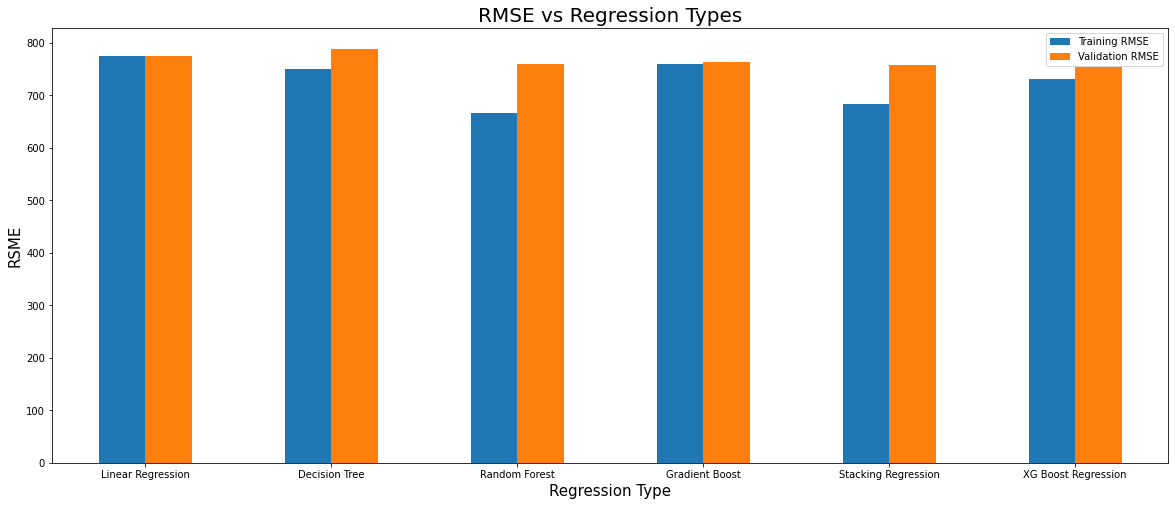

In [59]:
training_rmse = [training_rmse_mlm, training_rmse_dtr, training_rmse_rfr_2, training_rmse_gbr, training_rmse_s_reg, training_rmse_xgb]
validation_rmse = [validation_rmse_mlm, validation_rmse_dtr, validation_rmse_rfr_2, validation_rmse_gbr, validation_rmse_s_reg, validation_rmse_xgb]
index = ['Linear Regression', 'Decision Tree', 'Random Forest',
         'Gradient Boost', 'Stacking Regression', 'XG Boost Regression']
df = pd.DataFrame({'Training RMSE': training_rmse,
                   'Validation RMSE': validation_rmse}, index=index)
ax = df.plot.bar(rot=0, figsize=(20,8))
plt.title("RMSE vs Regression Types",fontsize=20)
plt.xlabel("Regression Type",fontsize=15)
plt.ylabel("RSME",fontsize=15)
plt.show()